<a href="https://colab.research.google.com/github/david-j-cox/Man-vs-Machine/blob/master/Police_Stops_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background information
*   This notebooks contains the data analytic pipeline for the manuscript titled "Understanding Policing: A Quantitative Analysis" and submitted to *Perspectives on Behavior Science*.
*   Data for this notebook can be obtained from the Stanford Police Project: https://openpolicing.stanford.edu/data/. 

In [4]:
# Packages!!
import os
import sys
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Upload data 
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/MyDrive/Policing Data/Nashville/Data'
nash_raw_data = pd.read_csv("tn_nashville_2020_04_01.csv")
nash_data = nash_raw_data.copy()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Policing Data/Nashville/Data


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,8,15,16,17,22,23,24,25,29,30,31,32,33,35,36,37,38,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Sample of what the data looks like and the data types
nash_data.head()

,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,subject_sex,officer_id_hash,type,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_registration_state,notes,raw_verbal_warning_issued,raw_written_warning_issued,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
0,232947,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6,4403.0,611,27.0,black,male,80ed1b32eb,vehicular,investigative stop,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,investigative stop,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
1,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5,9035.0,513,18.0,white,male,a983204b21,vehicular,moving traffic violation,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,moving traffic violation,TN,NaN,False,False,True,NaN,N,False,False,False,False,False,False,False
2,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1,5005.0,121,52.0,white,male,f5d8fbd78b,vehicular,vehicle equipment violation,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,vehicle equipment violation,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
3,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3,8891.0,325,25.0,white,male,4f1d028e45,vehicular,registration,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,registration,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
4,232780,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,NaN,NaN,NaN,21.0,black,male,0f0e6b7d67,vehicular,vehicle equipment violation,False,False,True,warning,False,False,False,False,True,True,True,probable cause,vehicle equipment violation,TN,NaN,True,False,False,NaN,N,True,True,False,False,False,False,False


In [7]:
# Create year and month cols for grouping
nash_data['year'] = pd.DatetimeIndex(nash_data['date']).year
nash_data['month'] = pd.DatetimeIndex(nash_data['date']).month

# Distributions of stops and putative reinforcers per month for all officers

In [8]:
# Create individual data frames for the different independent and dependent variables
offcr_stops = nash_data.groupby(['year', 'month', 'officer_id_hash']).size()
offcr_cites = nash_data.groupby(['year', 'month', 'officer_id_hash', 'citation_issued']).size()
offcr_search = nash_data.groupby(['year', 'month', 'officer_id_hash', 'search_conducted']).size()
offcr_frisk = nash_data.groupby(['year', 'month', 'officer_id_hash', 'frisk_performed']).size()
offcr_contra = nash_data.groupby(['year', 'month', 'officer_id_hash', 'contraband_found']).size()
offcr_arrest = nash_data.groupby(['year', 'month', 'officer_id_hash', 'arrest_made']).size()

In [9]:
# Print descriptions of each subset dataframe 
from scipy.stats import skew
grouped_data = [offcr_stops, offcr_cites, offcr_search, offcr_frisk, offcr_contra, offcr_arrest]
data_type = ['Stops', 'Citations', 'Searches', 'Frisks', 'Contraband Found', 'Arrests']

for i in range(len(grouped_data)):
  print(data_type[i], "| Skew =", round(skew(grouped_data[i]), 4), "\n", grouped_data[i].describe(), "\n")

Stops | Skew = 3.2648 
 count    85841.000000
mean        36.024044
std         45.549907
min          1.000000
25%          6.000000
50%         22.000000
75%         50.000000
max        675.000000
dtype: float64 

Citations | Skew = 3.2679 
 count    141332.000000
mean         21.877706
std          31.623313
min           1.000000
25%           3.000000
50%           9.000000
75%          30.000000
max         461.000000
dtype: float64 

Searches | Skew = 3.8236 
 count    119394.000000
mean         25.899978
std          40.414383
min           1.000000
25%           2.000000
50%           9.000000
75%          36.000000
max         675.000000
dtype: float64 

Frisks | Skew = 3.5768 
 count    106677.000000
mean         28.987673
std          42.403277
min           1.000000
25%           3.000000
50%          12.000000
75%          41.000000
max         675.000000
dtype: float64 

Contraband Found | Skew = 14.379 
 count    46182.000000
mean         2.765255
std          5.041673

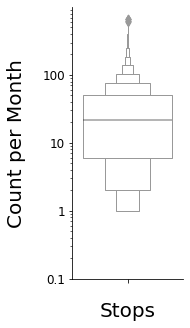

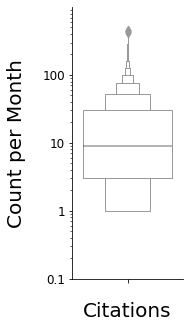

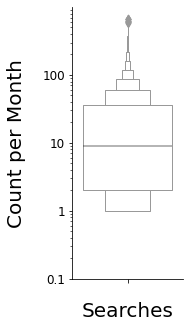

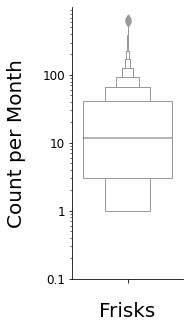

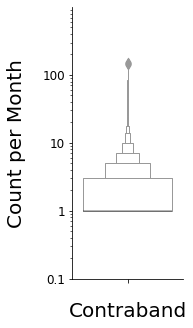

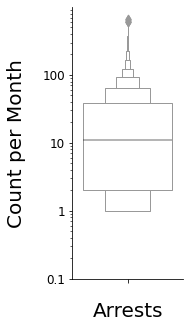

In [10]:
# Plot letter-value plots / boxen plots of the different distributions. 
# NB: These are Figure 1 in the manuscript
def boxen(df, x_label):
  f, ax = plt.subplots(figsize=(2, 5))
  sns.boxenplot(y=df, color='white')
  plt.xlabel(x_label, fontsize=20, labelpad=(16))
  plt.ylabel('Count per Month', fontsize=20, labelpad=(16))
  plt.ylim(.1, 1000)
  plt.yscale("log")
  plt.yticks(ticks=[.1, 1, 10, 100], labels=['0.1', '1', '10', '100'], fontsize=12)
  # plt.yticks(fontsize=12)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

boxen(offcr_stops, 'Stops')
boxen(offcr_cites, 'Citations')
boxen(offcr_search, 'Searches')
boxen(offcr_frisk, 'Frisks')
boxen(offcr_contra, 'Contraband')
boxen(offcr_arrest, 'Arrests')

# Define single-alternative matching equation

In [11]:
# Define single alternative matching equation and import packages we'll need to
# play with it.  
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def single_match(x, k, re):
  return (k*x)/(x+re)

# Fit single-alternative matching to each officer's data

In [15]:
# Function for fitting single-alternative equation
def single_matching(df, unique_identifier, df_reinforcer, reinforcer_label, 
                    fit_df_name, subset_cat=None, month=False):
  """
    Function Inputs:
    ----------
    df: Dataframe from which to subset the individual officer data. 
    unique_identifier: Dataframe column containing the individual person id. 
    df_reinforcer: The column that contains the reinforcer being tested. 
    reinforcer_label: The label to assign to the reinforcer being tested. 
    fit_df_name: Name of the fit dataframe that is saved by running this function. 
    subset_cat: Column to subsetting df for fitting across different categories.
    month: True if binning by month and year. False if binning only by year. 

    DESCRIPTION: This function fits the single-altenative matching equation 
        (Herrnstein, 1970) to behavior data binned per month for every 
        officer in this dataframe. It is designed so you can run through a loop 
        and test a variety of potential reinforcers in your data set, determine 
        which one best describes each officer's data, and save the results. 

    Returns:
    -------
    None. Pandas dataframe automatically saved after every officer. The 
    auto-saved dataframe contains:
      (1) Unique officer id number
      (2) Reinforcer label
      (3) The subset category of the data for each fit (if specified)
      (4) The estimated k parameter for the single-alternative matching equation. 
      (5) The estimated Re parameter for the single-alternative matching equation. 
      (6) The variance accounted for by the single-alternative matching equation. 
  """
  # Create list of all the unique officers in the dataset
  uniq_persons = df[unique_identifier].unique()
  
  # Lists for storing data
  person_num = []
  fit_type = []
  reinforcer_type = []
  k_val = []
  re_val = []
  r2_val = []
  error_list = []

  for i in uniq_persons:
    # Subset single officer data
    person_hash = i
    person_A = df[df[unique_identifier]==i]
    person_A = person_A[person_A['time'].notna()]
    person_A = person_A.reset_index()

    # Obtain rate of behavior per month and rate of citations per month
    person_reinforcer = person_A.groupby(['year', 'month'])[df_reinforcer].sum()
    person_behavior = person_A.groupby(['year', 'month']).size()

    if len(person_behavior) > 5:
      try:
        reinforcer_per_day = person_reinforcer / 30.42  # Convert to rate per day
        behavior_per_day = person_behavior / 30.42  # Convert to rate per day

        # Fit the single-alt matching equation to the officer data
        behavior = behavior_per_day.values
        reinforcer = reinforcer_per_day.values
        c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
        preds_from_obs = single_match(reinforcer, *c)  # Make predictions based on model params
        r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

        # Append data to cols
        person_num.append(person_hash)
        reinforcer_type.append(reinforcer_label)
        fit_type.append('overall')
        k_val.append(c[0])
        re_val.append(c[1])
        r2_val.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

        # Run the same analysis, but grouped by race
        # Calculate rate of behavior per day and rate of citations per day
        if month==True:
          person_reinforcer = person_A.groupby(['year', 'month', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', 'month', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 30.42
          behavior_per_day = person_behavior / 30.42
        else:
          person_reinforcer = person_A.groupby(['year', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 12
          behavior_per_day = person_behavior / 12
        reinforcer_per_day = reinforcer_per_day.fillna(0)
        behavior_per_day = behavior_per_day.fillna(0)

        # Loop through each race and fit the model
        cols = list(reinforcer_per_day)
        race_plot = []
        k_plot = []
        re_plot = []
        r2_plot = []

        for k in cols:
          behavior = behavior_per_day[k].values
          reinforcer = reinforcer_per_day[k].values
          param_seeds = [16, 5]
          c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
          preds_from_obs = single_match(reinforcer, *c) # Make predictions based on model params
          r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

          # Append data to cols
          person_num.append(person_hash)
          reinforcer_type.append(reinforcer_label)
          fit_type.append(k)
          race_plot.append(k)
          k_val.append(c[0])
          k_plot.append(c[0])
          re_val.append(c[1])
          re_plot.append(c[1])
          r2_val.append(round(r_2, 4))
          r2_plot.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('All_Fits_Citations.csv')
    
      except:
        print('Error with person %s' %i)
        error_list.append(i)
        err_officers = pd.DataFrame(error_list)
        err_officers.to_csv('Error_List_%s.csv' %reinforcer_label)
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

In [ ]:
# Citations as putative reinforcer binned by month
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='citation_issued', reinforcer_label='citations', 
                fit_df_name='All_Fits_Citations', subset_cat='subject_race', 
                month=True)

In [ ]:
# Searches as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='search_conducted', reinforcer_label='searches', 
                fit_df_name='All_Fits_Searches', subset_cat='subject_race')

In [ ]:
# Frisk as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='frisk_performed', reinforcer_label='frisks', 
                fit_df_name='All_Fits_Frisks', subset_cat='subject_race')

Person 80ed1b32eb finished, overall.
Person 80ed1b32eb finished for subset categories.
Person a983204b21 finished, overall.
Error with person a983204b21
Person f5d8fbd78b finished, overall.
Person f5d8fbd78b finished for subset categories.
Person 4f1d028e45 finished, overall.
Person 4f1d028e45 finished for subset categories.
Person 0f0e6b7d67 finished, overall.
Person 0f0e6b7d67 finished for subset categories.
Person 5a96851d64 finished, overall.
Person 5a96851d64 finished for subset categories.
Person 7226a00c28 finished, overall.
Person 7226a00c28 finished for subset categories.
Person c64917c4fe finished, overall.
Person c64917c4fe finished for subset categories.
Person 50529da1cb finished, overall.
Person 50529da1cb finished for subset categories.
Person 72037bef5d finished, overall.
Person 72037bef5d finished for subset categories.
Person b96df3310a finished, overall.
Person b96df3310a finished for subset categories.
Person 4ba28a89d9 finished, overall.
Person 4ba28a89d9 finished 

In [ ]:
# Contraband as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='contraband_found', reinforcer_label='contraband', 
                fit_df_name='All_Fits_Contraband', subset_cat='subject_race')

In [ ]:
# Arrests as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='arrest_made', reinforcer_label='arrests', 
                fit_df_name='All_Fits_Arrests', subset_cat='subject_race')

In [ ]:
# Combine all fit dataframes into single dataframe
df1 = pd.read_csv('All_Fits_Citations.csv')
df1 = df1.drop(['Unnamed: 0'], axis=1)
df2 = pd.read_csv('All_Fits_Searches.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1)
df3 = pd.read_csv('All_Fits_Frisks.csv')
df3 = df3.drop(['Unnamed: 0'], axis=1)
df4 = pd.read_csv('All_Fits_Contraband.csv')
df4 = df4.drop(['Unnamed: 0'], axis=1)
df5 = pd.read_csv('All_Fits_Arrests.csv')
df5 = df5.drop(['Unnamed: 0'], axis=1)

all_fits = df1.append([df2, df3, df4, df5])
all_fits.to_csv('All_Single_Alt_Matching_Fits.csv')

In [ ]:
all_fits.columns = ['person_num', 'reinforcer', 'fit_type', 'est_k', 'est_re', 'vac']

# Proportion descriptions for ms

In [ ]:
# Distribution vals for everything
pd.set_option('max_colwidth', 30) 
pd.set_option('max_rows', len(all_fits))
all_fits.groupby(['fit_type', 'reinforcer']).describe()

In [ ]:
# Print the proportion of officers whose databehavior was described by the 
# single-alternative matching equation with vac greater than 90%
print((round((cite_fits['r^2'].ge(0.9).sum())/len(cite_fits), 5)), "= Citation Proportion >90%")
print((round((search_fits['r^2'].ge(0.9).sum())/len(search_fits), 5)), "= Search Proportion >90%")
print((round((frisk_fits['r^2'].ge(0.9).sum())/len(frisk_fits), 5)), "= Frisk Proportion >90%")
print((round((contra_fits['r^2'].ge(0.9).sum())/len(contra_fits), 5)), "= Contraband Found Proportion >90%")
print((round((arrest_fits['r^2'].ge(0.9).sum())/len(arrest_fits), 5)), "= Arrest Proportion >90%")

In [ ]:
# Print the proportion of officers whose databehavior was described by the 
# single-alternative matching equation with vac greater than 80%
print((round((cite_fits['r^2'].ge(0.8).sum())/len(cite_fits), 5)), "= Citation Proportion >80%")
print((round((search_fits['r^2'].ge(0.8).sum())/len(search_fits), 5)), "= Search Proportion >80%")
print((round((frisk_fits['r^2'].ge(0.8).sum())/len(frisk_fits), 5)), "= Frisk Proportion >80%")
print((round((contra_fits['r^2'].ge(0.8).sum())/len(contra_fits), 5)), "= Contraband Found Proportion >80%")
print((round((arrest_fits['r^2'].ge(0.8).sum())/len(arrest_fits), 5)), "= Arrest Proportion >80%")

In [ ]:
# Print the number of officers for whom:
# VAC > 90%
print(cite_fits['r^2'].ge(0.9).sum(), "= Citation Count")
print(search_fits['r^2'].ge(0.9).sum(), "= Search Count")
print(frisk_fits['r^2'].ge(0.9).sum(), "= Frisk Count")
print(contra_fits['r^2'].ge(0.9).sum(), "= Contraband Count")
print(arrest_fits['r^2'].ge(0.9).sum(), "= Arrest Count")

# VAC > 80%
print(cite_fits['r^2'].ge(0.8).sum(), "= Citation Count")
print(search_fits['r^2'].ge(0.8).sum(), "= Search Count")
print(frisk_fits['r^2'].ge(0.8).sum(), "= Frisk Count")
print(contra_fits['r^2'].ge(0.8).sum(), "= Contraband Count")
print(arrest_fits['r^2'].ge(0.8).sum(), "= Arrest Count")

In [ ]:
def offcrs_90(df):
  temp_list = []
  reinf = []
  for i in range(len(df)):
    if df['r^2'][i]>=0.90:
      if df['officer_num'][i] in temp_list:
        continue
      else:
        temp_list.append(df['officer_num'][i])
        reinf.append(df['reinforcer'][i])
  return pd.DataFrame(list(zip(temp_list, reinf)), columns=['officer_num', 'reinforcer'])

cites_offcr = offcrs_90(cite_fits)
search_offcr = offcrs_90(search_fits)
frisk_offcr = offcrs_90(frisk_fits)
contra_offcr = offcrs_90(contra_fits)
arrest_offcr = offcrs_90(arrest_fits)

In [ ]:
# Combine all officer dfs where VAC was .90 or greater
all_offcr90s = cites_offcr.append(search_offcr)
all_offcr90s = all_offcr90s.append(frisk_offcr)
all_offcr90s = all_offcr90s.append(contra_offcr)
all_offcr90s = all_offcr90s.append(arrest_offcr)

In [ ]:
# Show value counts for all_offcr90s df
print("Unique Officers: %s" %len(all_offcr90s['officer_num'].unique()))
offcr90_val_counts = pd.DataFrame(all_offcr90s.value_counts(), columns=['count'])
offcr90_val_counts['count'].unique()

Unique Officers: 750


array([1])

# Distribution comparisons for ms

In [ ]:
all_fits = all_fits.rename(columns={'r^2':'vac'})

,officer_num,reinforcer,fit_type,est_k,est_re,vac
0,f5d8fbd78b,arrest,overall,18.901578,-1.552251,0.9500
1,f5d8fbd78b,arrest,asian/pacific islander,1.000000,1.000000,-0.6531
2,f5d8fbd78b,arrest,black,5.691206,0.204894,0.8549
3,f5d8fbd78b,arrest,hispanic,7.666667,1.000000,0.3405
4,f5d8fbd78b,arrest,unknown,1.000000,1.000000,-0.2857
...,...,...,...,...,...,...
42956,3afeff7dc4,contraband,white,1.000000,1.000000,-0.5079
42957,00fd1ebe22,contraband,overall,1.000000,1.000000,-1.3333
42958,00fd1ebe22,contraband,black,1.000000,1.000000,-1.0000
42959,00fd1ebe22,contraband,other,1.000000,1.000000,-0.3333


In [ ]:
import statsmodels as sm
from statsmodels.formula.api import ols
model = ols('vac ~ C(fit_type, Sum)*C(reinforcer, Sum)', data=all_fits)
results = model.fit()
table = sm.stats.anova.anova_lm(results, typ=2)
print(table)

                                            sum_sq  ...         PR(>F)
C(fit_type, Sum)                       1500.247205  ...   7.319772e-40
C(reinforcer, Sum)                     6264.998592  ...  1.109357e-175
C(fit_type, Sum):C(reinforcer, Sum)    1574.732886  ...   4.474112e-31
Residual                             325761.007362  ...            NaN

[4 rows x 4 columns]


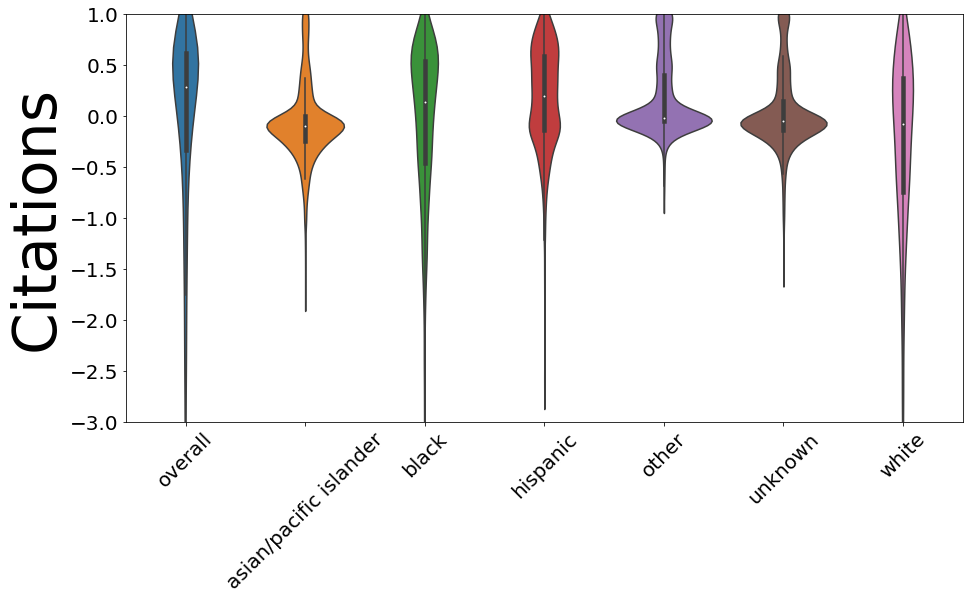

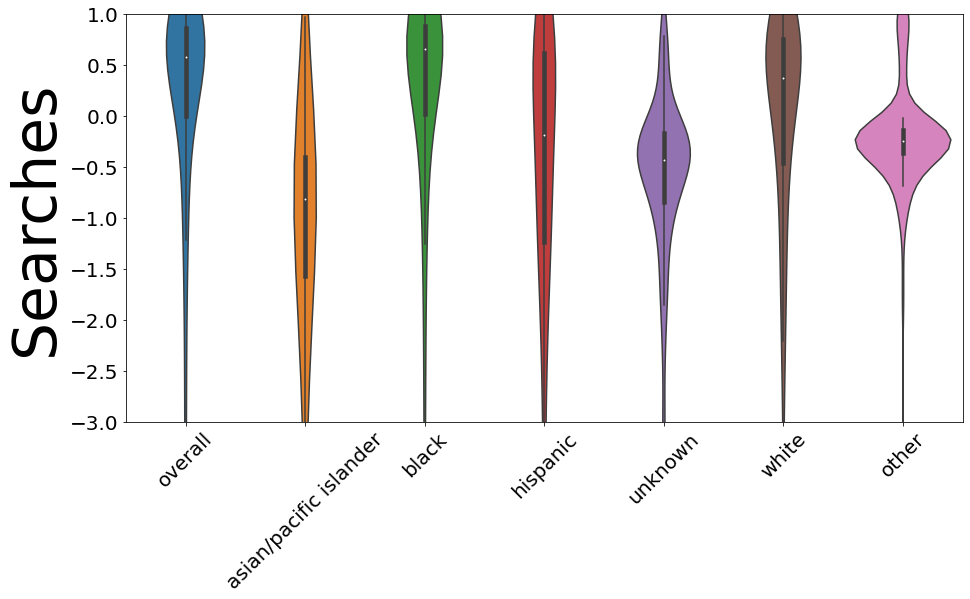

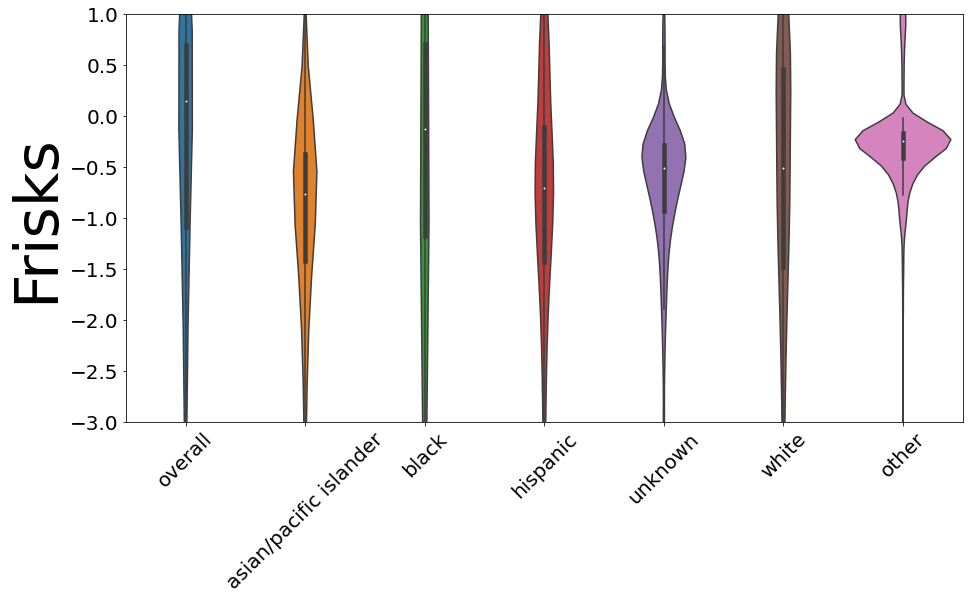

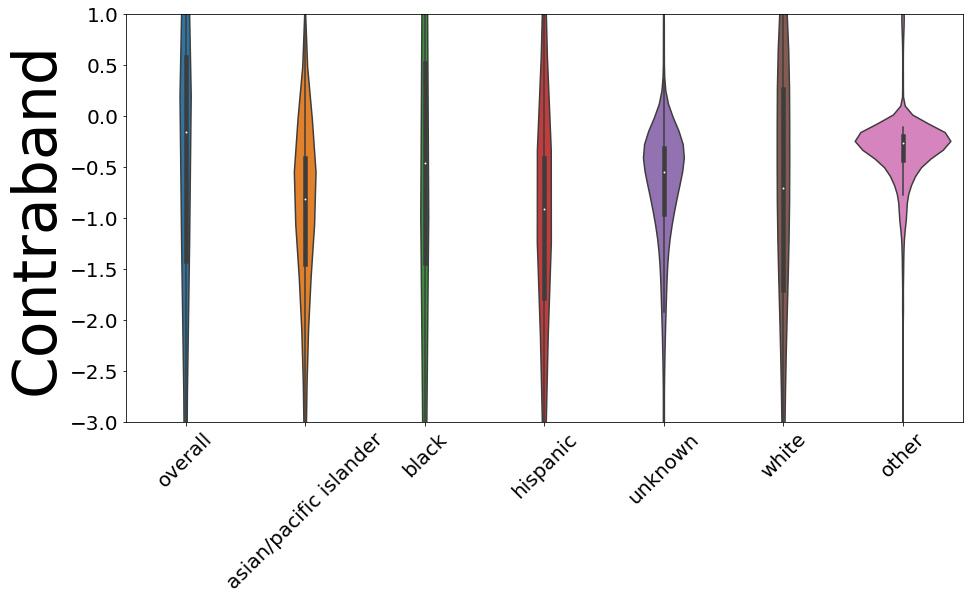

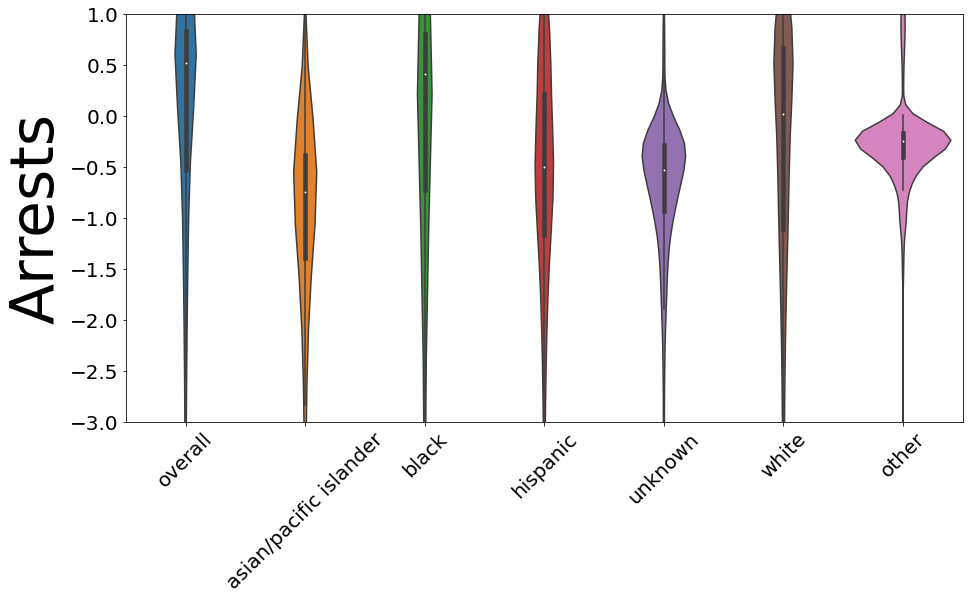

In [ ]:
def violin_plot(x, y, ylabel, ymin, ymax):
  plt.figure(figsize=(15, 7.5))
  sns.violinplot(x=x, y=y)
  plt.xlabel('', fontsize=30)
  plt.ylabel(ylabel, fontsize=60)
  plt.ylim(ymin, ymax)
  plt.xticks(fontsize=20, rotation=45)
  plt.yticks(fontsize=20)
  return plt.show()

violin_plot(x=cite_fits['fit_type'], y=cite_fits['r^2'], ylabel='Citations', ymin=-3, ymax=1)
violin_plot(x=search_fits['fit_type'], y=search_fits['r^2'], ylabel='Searches', ymin=-3, ymax=1)
violin_plot(x=frisk_fits['fit_type'], y=frisk_fits['r^2'], ylabel='Frisks', ymin=-3, ymax=1)
violin_plot(x=contra_fits['fit_type'], y=contra_fits['r^2'], ylabel='Contraband', ymin=-3, ymax=1)
violin_plot(x=arrest_fits['fit_type'], y=arrest_fits['r^2'], ylabel='Arrests', ymin=-3, ymax=1)

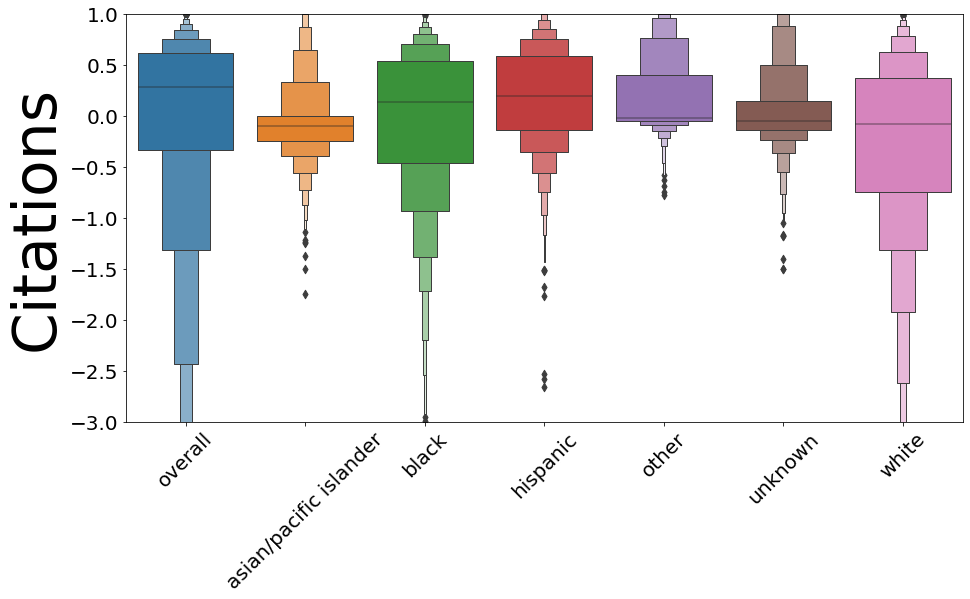

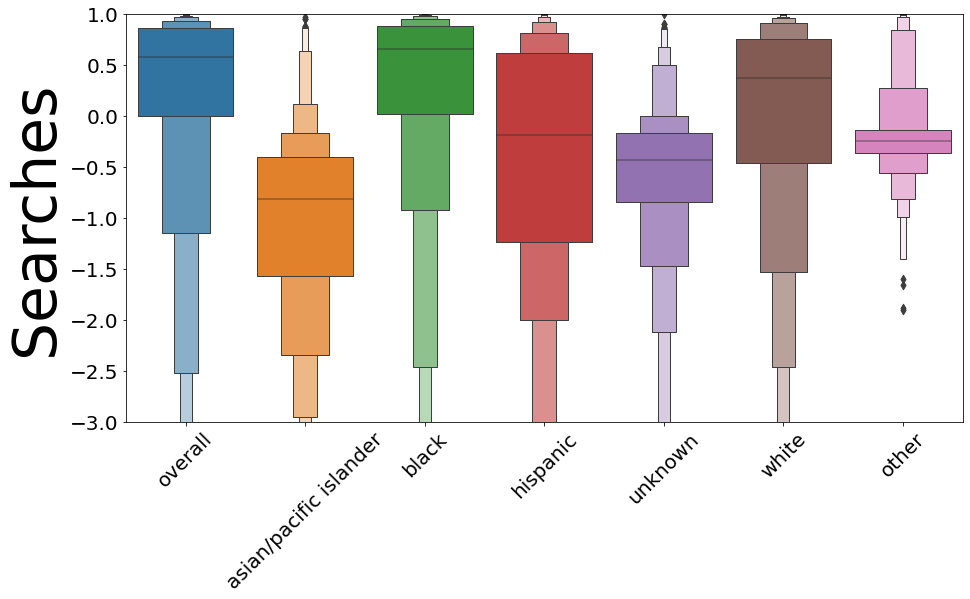

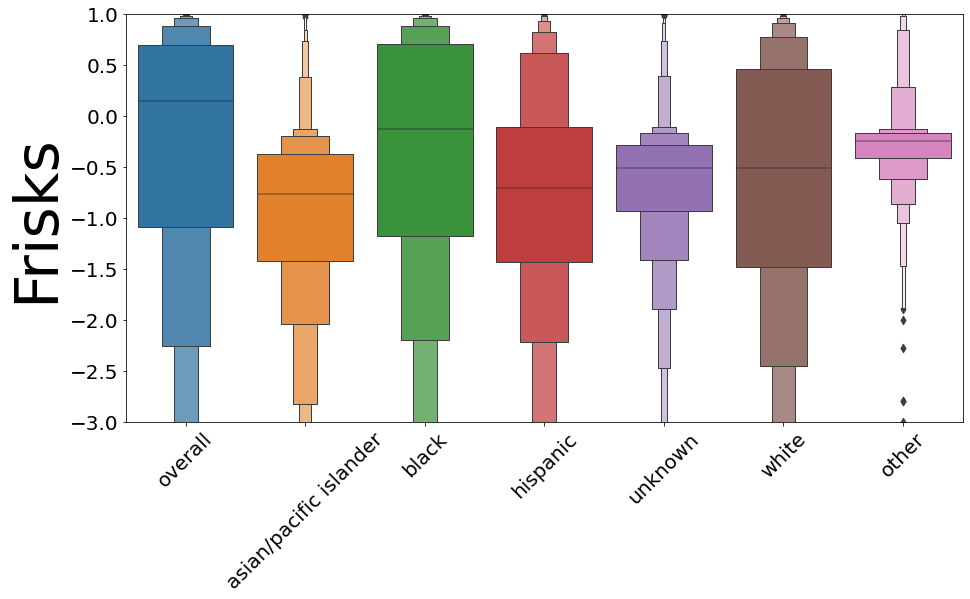

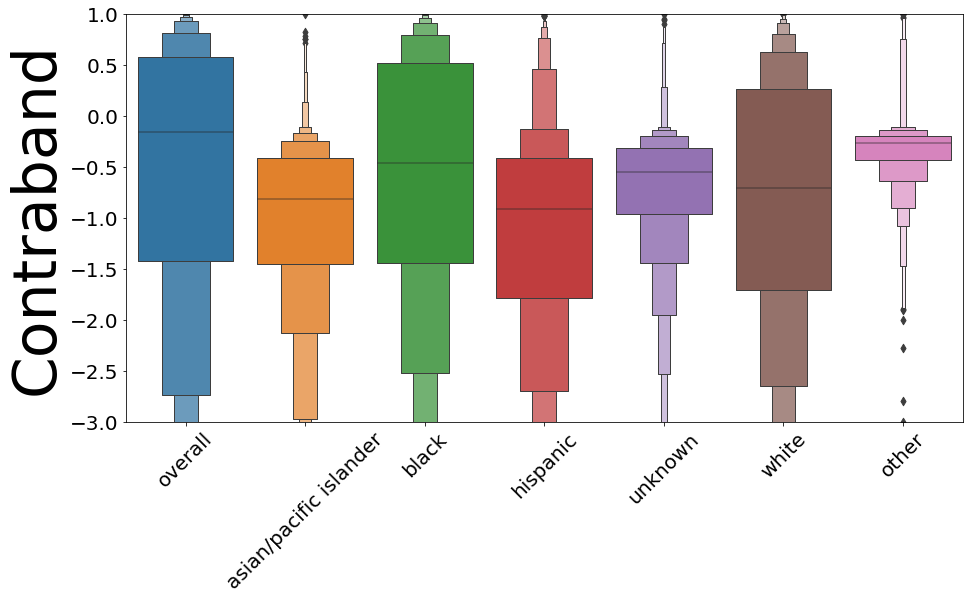

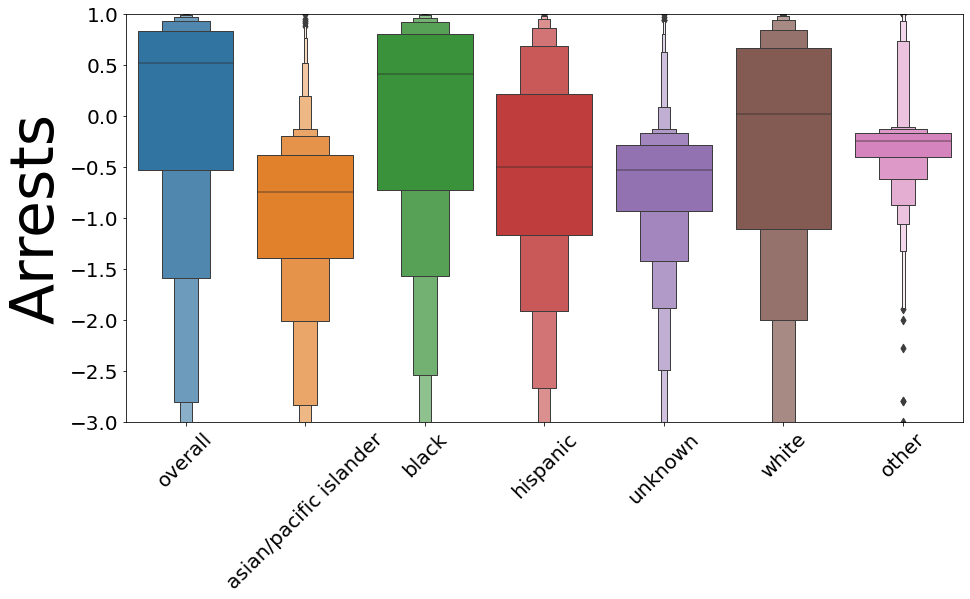

In [ ]:
def boxen_plots(x, y, ylabel, ymin, ymax):
  plt.figure(figsize=(15, 7.5))
  sns.boxenplot(x=x, y=y)
  plt.xlabel('', fontsize=30)
  plt.ylabel(ylabel, fontsize=60)
  plt.ylim(ymin, ymax)
  plt.xticks(fontsize=20, rotation=45)
  plt.yticks(fontsize=20)
  return plt.show()

boxen_plots(x=cite_fits['fit_type'], y=cite_fits['r^2'], ylabel='Citations', ymin=-3, ymax=1)
boxen_plots(x=search_fits['fit_type'], y=search_fits['r^2'], ylabel='Searches', ymin=-3, ymax=1)
boxen_plots(x=frisk_fits['fit_type'], y=frisk_fits['r^2'], ylabel='Frisks', ymin=-3, ymax=1)
boxen_plots(x=contra_fits['fit_type'], y=contra_fits['r^2'], ylabel='Contraband', ymin=-3, ymax=1)
boxen_plots(x=arrest_fits['fit_type'], y=arrest_fits['r^2'], ylabel='Arrests', ymin=-3, ymax=1)

# Individual officer matching plots for ms

In [ ]:
# Create data for plotting the curve predicted by the single-alternative matching
cites_pred = np.linspace(0, cites_per_day.max(), 100)
stop_pred = []
for j in list(range(len(cites_pred))): # Predicted stops
  pred = round(single_match(cites_pred[j], c[0], c[1]), 4)
  stop_pred.append(pred)

# Plot behavior (stops) as a function of putative reinforcers (citations)
plt.figure(figsize=(10, 7.5))
plt.scatter(x=cites_per_day, y=stops_per_day, marker='o', alpha=0.5, \
            color='black', s=100)
plt.plot(cites_pred, stop_pred, marker='', linestyle='-', color='black')
plt.xlabel('Citations per Day', fontsize=30)
plt.ylabel('Stops per Day', fontsize=30)
plt.title('Officer ID: %s' %i, fontsize =14)
plt.text(cites_per_day.max(), 0, '$R^2$=%s' %'{}'.format(round(r_2, 2)), \
        fontsize=26, horizontalalignment='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('Officer_%s_Overall_Fit_Citations.png' %i)
plt.show()

      # Combine race fits into single df for easier plotting by race
fits_by_race = pd.DataFrame({"est_k":k_plot, "est_re":re_plot, "r^2":r2_plot, "race":list(cites_per_day)})

# Create data for plotting the curve predicted by the single-alternative matching
cites_pred = np.linspace(0, cites_per_day.max(), 100)

# Predictions for Asian/Pacific Islander
api_pred = []
for m in list(range(len(cites_pred))):
  pred = single_match(cites_pred[m], fits_by_race['est_k'][0], fits_by_race['est_re'][0])
  api_pred.append(pred)

# Predictions for Black
black_pred = []
for m in list(range(len(cites_pred))):
  pred = single_match(cites_pred[m], fits_by_race['est_k'][1], fits_by_race['est_re'][1])
  black_pred.append(pred)

# Predictions for Hispanic
hispanic_pred = []
for m in list(range(len(cites_pred))):
  pred = single_match(cites_pred[m], fits_by_race['est_k'][2], fits_by_race['est_re'][2])
  hispanic_pred.append(pred)

# Predictions for White
white_pred = []
for m in list(range(len(cites_pred))):
  pred = single_match(cites_pred[m], fits_by_race['est_k'][5], fits_by_race['est_re'][5])
  white_pred.append(pred)

# PLot behavior (stops) as a function of putative reinforcers (citations)
plt.figure(figsize=(10, 7.5))

# Raw Data
plt.scatter(x=cites_per_day['asian/pacific islander'], y=stops_per_day['asian/pacific islander'], marker='o', alpha=0.5, \
            color='black', s=100, label='Asian/Pacific Islander')
plt.scatter(x=cites_per_day['black'], y=stops_per_day['black'], marker='o', alpha=0.5, \
            color='blue', s=100, label='Black')
plt.scatter(x=cites_per_day['hispanic'], y=stops_per_day['hispanic'], marker='o', alpha=0.5, \
            color='red', s=100, label='Hispanic')
plt.scatter(x=cites_per_day['white'], y=stops_per_day['white'], marker='o', alpha=0.5, \
            color='green', s=100, label='White')

# Prediction Curves
plt.plot(cites_pred, api_pred, marker='', linestyle='-', color='black')
plt.plot(cites_pred, black_pred, marker='', linestyle='-', color='blue')
plt.plot(cites_pred, hispanic_pred, marker='', linestyle='-', color='red')
plt.plot(cites_pred, white_pred, marker='', linestyle='-', color='green')
plt.plot(cites_pred, cites_pred, marker='', linestyle='--', color='gray')

# Details
plt.xlabel('Citations per Day', fontsize=30)
plt.ylabel('Stops per Day', fontsize=30)
plt.legend(fontsize=20, framealpha=0, bbox_to_anchor=(1, 0.95))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Officer ID: %s' %i, fontsize=14)
plt.savefig('Officer_%s_Fit_by_Race_Citations.png' %i)
plt.show()